# Deterministic Model 02: Model parameters

In [23]:
# install libraries
#%pip install pandas
#%pip install numpy

In [24]:
# import pandas library
import pandas as pd
import numpy as np

### Read Data

In [25]:
# Read the file and assign it to variable "df_real"
other_path = '../../data/sim/merged_data.csv'
df = pd.read_csv(other_path, header=0)

In [26]:
# show the first 5 rows using dataframe.head() method
print('The first 5 rows of the dataframe')
df.head(5)

The first 5 rows of the dataframe


,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44


### Setting parameters of Robotic System

In [27]:
# robotics specification
speed_max_load = 0.5    # m/sec, speed TCP with load
speed_max_unload = 1.0  # m/sec, speed TCP without load
accel = 1               # m/sec2, acceleration TCP

time_to_max_load_speed = speed_max_load / accel
dist_to_max_load_speed = (1/2) * accel * time_to_max_load_speed

time_to_max_unload_speed = speed_max_unload / accel
dist_to_max_unload_speed = (1/2) * accel * time_to_max_unload_speed



range_max = 3_904       # mm, working max range
range_min = 1_912       # mm, working min range (aproximate

# brick robots specification
time_suck_on = 1.5          # sec
time_suck_off = 0.5         # sec
time_verif_refer = 3.5      # sec
time_refer_pallete = 2.1    # sec

# coordinates of reference point
refer_x = 500           # mm in coordinate system
refer_y = 2_450         # mm in coordinate system
refer_z = 1_500         # mm in coordinate system

# position of robotic arm
robot_x = 2_250         # mm in coordinate system
robot_y = 2_420         # mm in coordinate system
robot_z = 1_000         # mm in coordinate system

# parameters of simulation
grid_simulation = 100    # mm, grid simulation

### Calculation based on real data

In [28]:
# average time from pallete to verification table
time_pallete_verif = df['start_to_verif'].mean() + time_suck_on
time_pallete_verif


9.754901960784315

### Calculate total cycle time

In [29]:
def simulate_time(dist):
    total_time = time_suck_on + time_pallete_verif
    total_time += time_suck_off + time_suck_on + time_verif_refer
    total_time += (dist - dist_to_max_load_speed) / 1_000 / speed_max_load
    total_time += time_suck_off + time_refer_pallete
    total_time += (dist - dist_to_max_unload_speed) / 1_000 / speed_max_unload
    total_time += time_to_max_load_speed + time_to_max_unload_speed
    return total_time

In [30]:
df['total_time_calc'] = df.apply(lambda x : simulate_time(x['dist']) , axis=1)
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_calc
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40,29.046902
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38,28.641902
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36,27.903902
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36,26.265902
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44,25.215902


### Modifying Real-World Data

In [31]:
koeff_correction = df['total_time'].mean() / df['total_time_calc'].mean()
df['total_time_calc'] = df['total_time_calc'] * koeff_correction

In [32]:
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_calc
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40,42.951555
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38,42.352683
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36,41.261405
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36,38.839300
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44,37.286669


### Checking linear distance from reference to wall

In [33]:
# coordinates of reference point
df['dist_linear'] = ((df['x'] - refer_x)**2 + (df['y'] - refer_y)**2 + ((df['z']+250) - refer_z)**2)**(1/2)
df.head(10)

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_calc,dist_linear
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40,42.951555,2680.844083
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38,42.352683,2544.033019
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36,41.261405,2176.809592
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36,38.839300,1796.802716
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44,37.286669,1378.767566
5,10,BASIC,1,90,220,2190,0,1,8,1409,6,14,14,34,37.087045,1307.096018
6,12,BASIC,1,90,220,2690,0,1,10,1450,8,12,14,34,37.268924,1303.265130
7,13,BASIC,1,90,220,2940,0,1,11,1532,8,12,26,46,37.632684,1371.495534
8,14,BASIC,1,90,220,3190,0,1,12,1648,8,12,14,34,38.147270,1479.357969
9,19,BASIC,1,90,220,4440,0,1,17,2538,10,8,38,56,42.095390,2366.643192


### Comparing real and modified real data

In [34]:
#%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='type_brick', ylabel='total_time'>

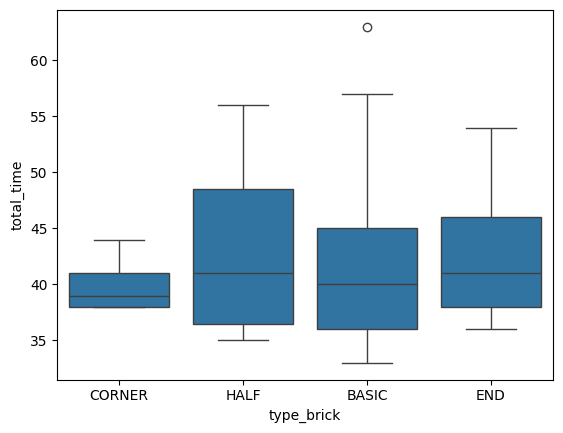

In [35]:
sns.boxplot(x='type_brick', y="total_time", data=df)

<Axes: xlabel='type_brick', ylabel='total_time_calc'>

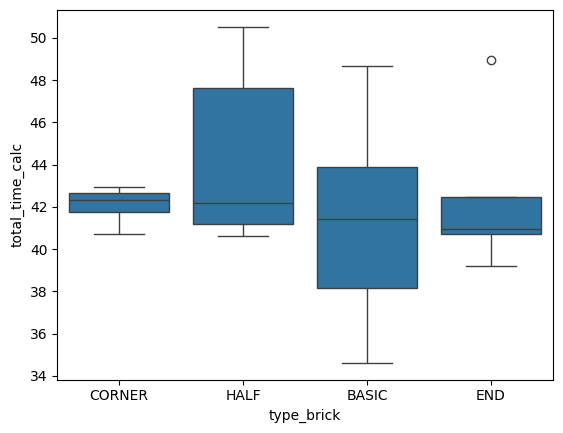

In [36]:
sns.boxplot(x='type_brick', y="total_time_calc", data=df)

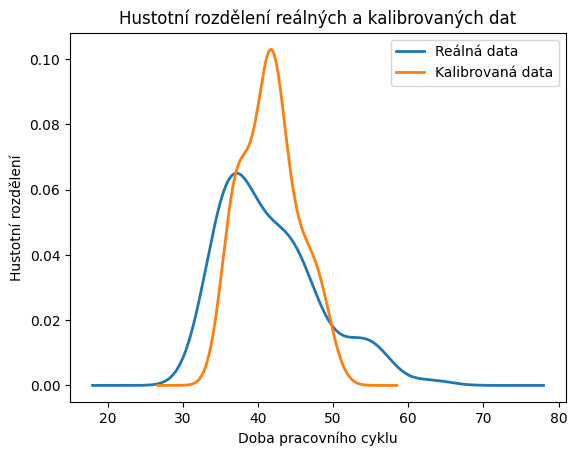

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot density
df['total_time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Reálná data')
df['total_time_calc'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Kalibrovaná data')
plt.legend()
plt.xlabel("Doba pracovního cyklu")
plt.ylabel("Hustotní rozdělení")
plt.title('Hustotní rozdělení reálných a kalibrovaných dat')
plt.show()

### Simulation for allowed points in Rhino + Grasshopper

In [38]:
# Read the file and assign it to variable "df_allowed_point"
other_path = '../../data/points/allowed_points.csv'
df_allowed_points = pd.read_csv(other_path, header=0)

In [39]:
df_allowed_points[['x','y','z']] = df_allowed_points[['x','y','z']].astype(int)
df_allowed_points.head(5)


,x,y,z
0,74,459,1284
1,-90,4908,2217
2,522,3074,26
3,425,2247,2739
4,516,3425,1590


### Generate simulation deterministic data

In [40]:
df_sim = df_allowed_points
df_sim['dist'] = ((df_sim['x'] - refer_x)**2 + (df_sim['y'] - refer_y)**2 + ((df_sim['z']+250) - refer_z)**2)**(1/2)
df_sim['total_time'] = df_sim.apply(lambda x : simulate_time(x['dist']) , axis=1)
df_sim['total_time'] = df_sim['total_time'] * koeff_correction
df_sim.head()

,x,y,z,dist,total_time
0,74,459,1284,2036.347957,39.870016
1,-90,4908,2217,2706.465038,42.842716
2,522,3074,26,1374.058223,36.932040
3,425,2247,2739,1504.644476,37.511332
4,516,3425,1590,1032.705670,35.417769


In [41]:
df_sim.describe()

,x,y,z,dist,total_time
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1422.944700,1336.856500,1374.817600,2435.292585,41.639771
std,1440.916105,1512.725045,805.317921,1090.305852,4.836695
min,-99.000000,-99.000000,0.000000,64.101482,31.120954
25%,248.000000,202.000000,676.000000,1577.850196,37.836079
50%,599.500000,521.000000,1374.500000,2402.055568,41.492328
75%,2591.250000,2435.000000,2076.000000,3159.976186,44.854532
max,4599.000000,4949.000000,2749.000000,5026.495598,53.134580


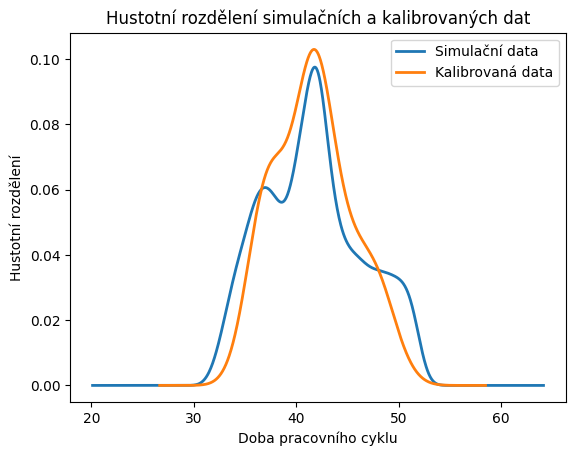

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot density
df_sim['total_time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Simulační data')
df['total_time_calc'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Kalibrovaná data')

plt.xlabel("Doba pracovního cyklu")
plt.ylabel("Hustotní rozdělení")
plt.title('Hustotní rozdělení simulačních a kalibrovaných dat')

plt.legend()
plt.show()

<h2>Save Dataset</h2>
<p>
Correspondingly, Pandas enables us to save the dataset to csv. By using the <code>dataframe.to_csv()</code> method, you can add the file path and name along with quotation marks in the brackets.
</p>
<p>
For example, if you would save the dataframe <b>df</b> as <b>automobile.csv</b> to your local machine, you may use the syntax below, where <code>index = False</code> means the row names will not be written.
</p>


In [43]:
df_sim.to_csv("../../data/sim/model_data.csv", index=False)
df.to_csv("../../data/sim/model_data_real.csv", index=False)

We can also read and save other file formats. We can use similar functions like **`pd.read_csv()`** and **`df.to_csv()`** for other data formats. The functions are listed in the following table:


#### Author/Date/Organization

Vjaceslav Usmanov, CTU in Prague

###### Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2026-01-20 | 1.1 | Vjaceslav Usmanov| added DM_02_Model_Parameters.ipynb |
| 2026-02-12 | 1.2 | Vjaceslav Usmanov| changed DM_02_Model_Parameters.ipynb |